# Template Notebook Evaluate offline models

Given a certain EXPERIMENT and RUN (selected by the user) saved in vertex experiments, show results of offline evaluation

In [1]:
# ---------------------------- read env variables used in the app ----------------------------
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
PROJECT_GCP = os.environ.get("PROJECT_GCP", "")
REGION_GCP = os.environ.get("REGION_GCP", "")
BUCKET_GCP = os.environ.get("BUCKET_GCP", "")

## RUN

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

import offline_evaluation as off_eval

### 1. Load model name - SELECTED BY THE USER
The user needs to specify:
- EXPERIMENT (vertex experiment): the name of the dataset loaded
- RUN (vertex experiment): the name of the model to evaluate

In [3]:
# PARAMETERS BY THE USER - use the previous codes to select the dataset and run between the choices saved
NAME_DATASET = 'develop-app-final-v2'
SELECTED_RUN = 'run-lr'

### 2. Load data train and test

In [4]:
X_train, y_train, X_test, y_test = off_eval.load_data(BUCKET_GCP, NAME_DATASET, SELECTED_RUN)

SHAPE DATA
X_train:  (74, 9)
y_train:  (74, 1)


X_test:  (17, 9)
y_test:  (17, 1)


### 3. Load model trained

In [5]:
# load model
path_model = f'gs://{BUCKET_GCP}/{NAME_DATASET}/{SELECTED_RUN}/model.pkl'
model = pd.read_pickle(path_model)

### 4. Load list features

In [6]:
list_features = X_train.columns.tolist()
list_target = y_train.columns.tolist()
list_features_target = list_features + list_target

## III) OFFLINE EVALUATION MODEL

### 0. Get predictions

In [7]:
y_test_pred = off_eval.get_predictions(model, X_test, y_test)

### 1. Metrics

#### 1.1 Metric for Model trained

In [8]:
metrics = off_eval.calculate_metrics_regressors_models(y = y_test, 
                                              y_pred = y_test_pred, 
                                              model_name = SELECTED_RUN, 
                                              decimals_round = None
                                             )

In [9]:
metrics

,r2,mse,rmse,rmse_mean_ratio(%),rmse_iqr_ratio(%),mae,mae_mean_ratio(%),mae_iqr_ratio(%)
run-lr,-46.144127,313.855513,17.715968,4.86,380.42,16.842967,4.62,361.68


#### 1.2 Basic Model - mean target / predict common class

In [10]:
# calculate mean y train. ADJUST BASIC MODEL
y_basic_model = y_train.mean().values[0]

# generate vector to y_pred to evaluate. obs generate len according the y_true when the mean prediction will be compared
y_basic_model_pred = pd.DataFrame(y_basic_model * np.ones([y_test.shape[0]]))
y_basic_model_pred.index = y_test.index
y_basic_model_pred.columns = y_test.columns

# metrics basic model
metrics_basic_model = off_eval.calculate_metrics_regressors_models(y = y_test, 
                                                          y_pred = y_basic_model_pred, 
                                                          model_name = 'd0eop_microkappa//Basic Model Pred', 
                                                          decimals_round = None
                                                         )

In [11]:
metrics_basic_model

,r2,mse,rmse,rmse_mean_ratio(%),rmse_iqr_ratio(%),mae,mae_mean_ratio(%),mae_iqr_ratio(%)
d0eop_microkappa//Basic Model Pred,-61.928837,418.94004,20.468025,5.61,439.52,20.304745,5.57,436.02


### 2. Plot Predictions

#### 2.1 y_true vs y_pred

In [12]:
y_true_y_pred = off_eval.plot_y_true_vs_y_pred(y = y_test, 
                                      y_pred = y_test_pred, 
                                      title_plot = SELECTED_RUN
                                     )

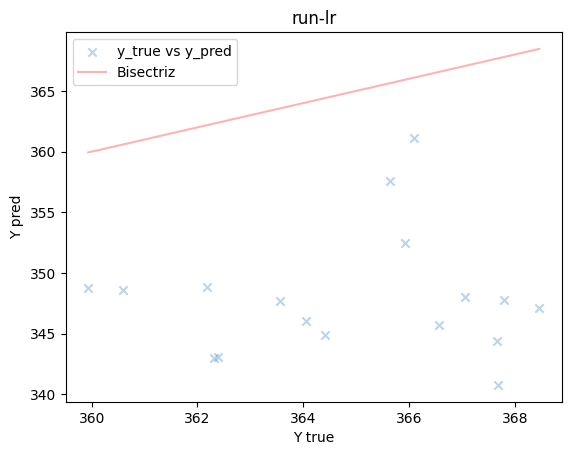

In [13]:
y_true_y_pred

#### 2.2 hist errors

In [14]:
hist_errors = off_eval.hist_errors_predictions(y = y_test, 
                                      y_pred = y_test_pred, 
                                        title_plot = SELECTED_RUN
                                   )

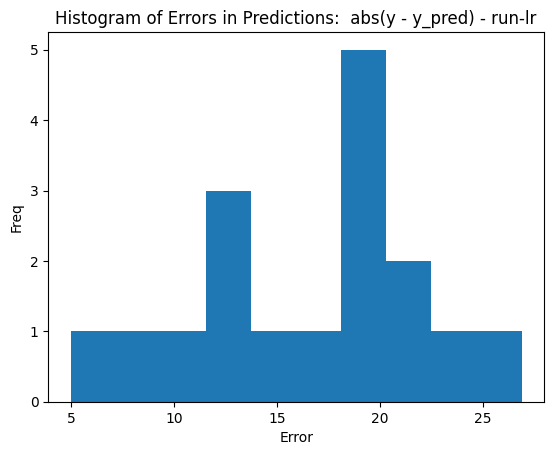

In [15]:
hist_errors

### 3. Explanaible AI

#### 3.1 Permutation Importances

In [16]:
plot_permutation_importances, df_importances = off_eval.permutation_importances(model, list_features, X_test, y_test)

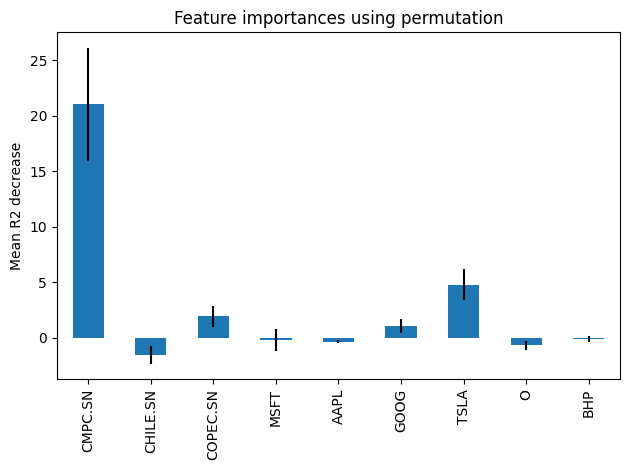

In [17]:
plot_permutation_importances

#### 3.2 Permutation Importances with Noise Features

In [18]:
plot_permutation_importances_noise = off_eval.permutation_importances_noise(model, X_train, y_train, X_test, y_test)

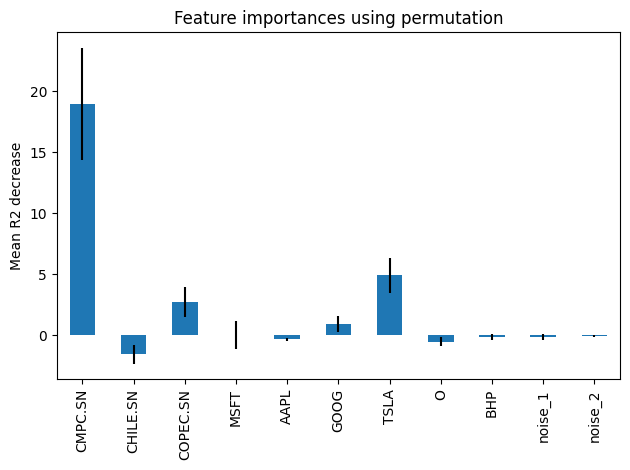

In [19]:
plot_permutation_importances_noise

#### 3.3 Partial Dependence Plot

In [20]:
fig_pdp = off_eval.pdp_plot(model, X_test)

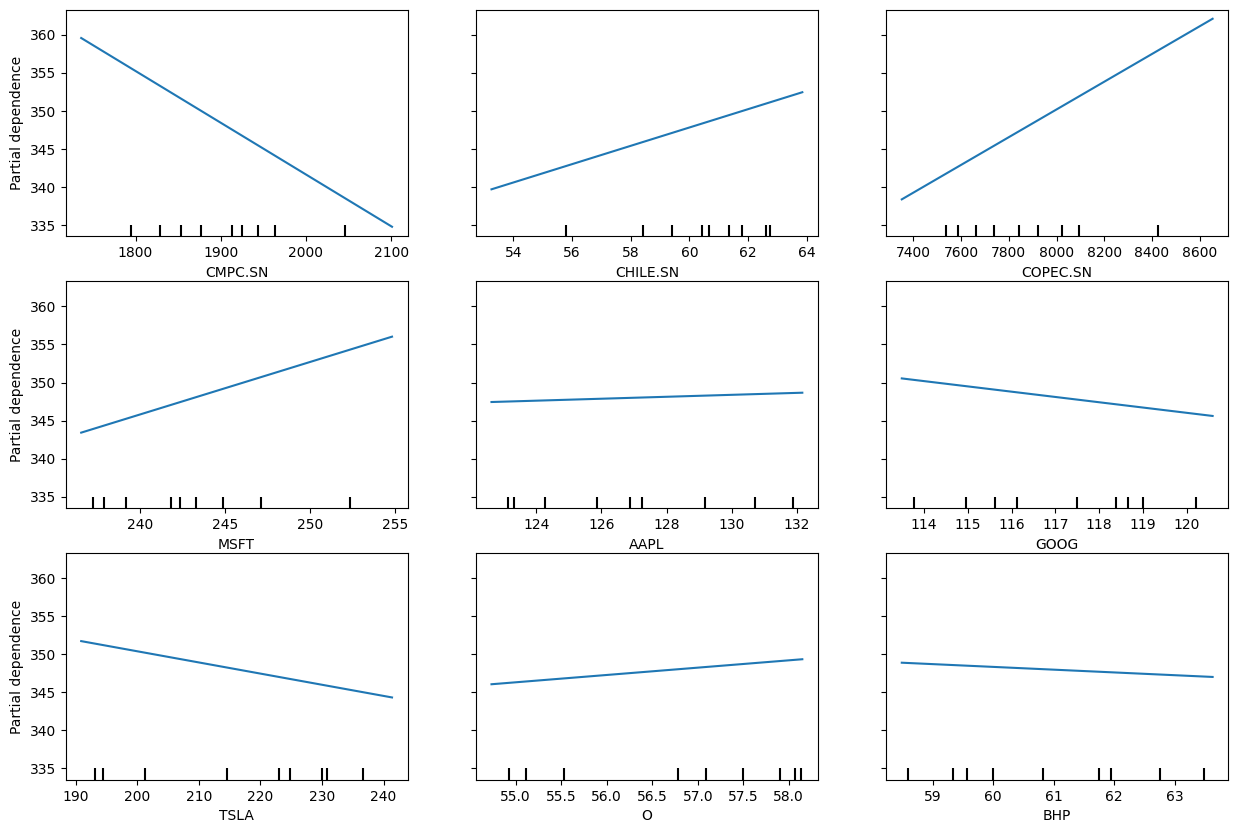

In [21]:
fig_pdp

#### 3.4 Shapley Values
Plots utilizando el package SHAP

In [22]:
# TO DO - shap values
# TO DO - shapash package

### 4. Perturbation test - Sensitivy Analysis

#### 4.1 Peturbation test one feature global plots

In [23]:
# get the most important feature
MOST_IMPORTANT_FEATURE = df_importances.sort_values(ascending = False).index.values[0]

In [24]:
fig_sensitivy_one_feature = off_eval.perturbation_test_one_feature_global_analysis(tag_sensitivy_analysis = MOST_IMPORTANT_FEATURE, # most important feature for example
                                                                                   epsilon = 1, 
                                                                                   model = model,
                                                                                   X = X_test.copy(), 
                                                                                   y = y_test.copy(), 
                                                                                   y_pred = y_test_pred.copy()
                                                                                  )

-- Epsilon percent impact: 0.05%


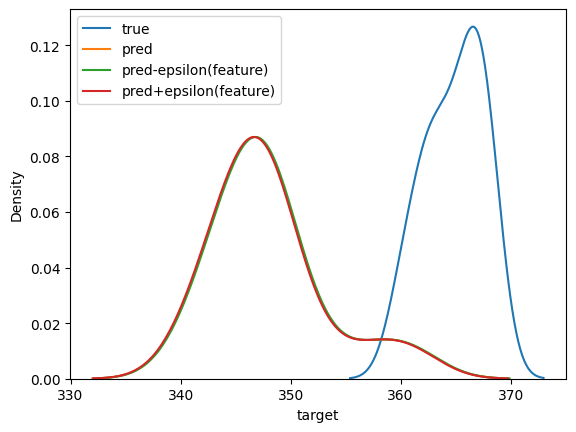

In [25]:
fig_sensitivy_one_feature

### 5. Metrics by segments

#### 5.1 Segment by most important feature

In [26]:
tag_segment = MOST_IMPORTANT_FEATURE

In [27]:
metrics_segmentation = off_eval.metrics_segmentation_analysis(tag_segment, X_test, y_test, y_test_pred, metrics)

In [28]:
metrics_segmentation

,r2,mse,rmse,rmse_mean_ratio(%),rmse_iqr_ratio(%),mae,mae_mean_ratio(%),mae_iqr_ratio(%)
run-lr,-46.144127,313.855513,17.715968,4.86,380.42,16.842967,4.62,361.68
Percentile 0,-105.051819,517.682712,22.752642,6.22,1050.01,22.571522,6.17,1041.65
Percentile 1,-465.609301,359.317922,18.955683,5.21,1884.51,18.944801,5.21,1883.43
Percentile 2,-77.391336,370.105977,19.238139,5.25,784.90,19.096377,5.21,779.12
Percentile 3,-19.314239,209.505304,14.474298,3.99,406.54,14.038901,3.87,394.31
Percentile 4,-42.117013,112.006314,10.583304,2.90,897.99,9.951030,2.73,844.34
